In [1]:
path = 'Potholes/annotated-images/'
splits = 'Potholes/splits.json'
data = 'proposals.pkl'
# path = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/annotated-images/'
# splits = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/splits.json'
#!unzip Potholes.zip

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.ops as ops
from xml.etree import ElementTree as ET
from torch.utils.data import DataLoader
from torchvision.io import decode_image
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split
import pickle

# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(8)

def selective_search(image_path, num_rects, quality=True):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    image = cv2.imread(image_path)
    ss.setBaseImage(image)

    ss.switchToSelectiveSearchFast()

    rects = ss.process()

    return rects[:num_rects]

def show_selective_search(image, rects):
    imOut = image.copy()

    # itereate over all the region proposals
    for _, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)

    plt.imshow(imOut[...,::-1])
    plt.axis('off')

def read_xml(path: str) -> list:
    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)

    return obj_list

def collate_fn(batch):
    return tuple(zip(*batch))

def visualize_boxes(images, annotations):
    all_images = []
    all_overlay = []

    for image, annotation in zip(images, annotations):

        overlay = draw_bounding_boxes(image, annotation, width=2)
        all_images.append(image)
        all_overlay.append(overlay)

    fig, axes = plt.subplots(len(all_images), 2, figsize=(10, len(all_images) * 5))

    for idx, image in enumerate(all_images):
        axes[idx, 0].imshow(image.permute(1,2,0))
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(all_overlay[idx].permute(1,2,0))
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

class RCNN(nn.Module):
    def __init__(self):
        super(RCNN, self).__init__()

        self.convolutional1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224x224 -> 112x112
        )

        self.convolutional2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112x112 -> 56x56
        )

        self.convolutional3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56x56 -> 28x28
        )

        self.convolutional4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        )

        # Fully connected layer
        self.fully_connected = nn.Sequential(
            nn.Linear(512 * 14 * 14, 2048),  # Adjusted to match the output size after 4 conv layers
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        x = self.convolutional4(x)

        x = x.view(x.size(0), -1)

        x = self.fully_connected(x)
        x = x.squeeze(1)

        return x



In [4]:
class Pothole_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, feature_size=256, pos_thresh=.6, neg_thresh=.3, val=False, device="cpu"):
        self.data = data
        self.size = feature_size
        self.pos_thresh = pos_thresh
        self.neg_thresh = neg_thresh
        self.val = val
        self.device = device

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        datum = self.data[idx]
        image = decode_image(datum[0]).to(self.device)
        ground_truths = datum[1].to(self.device)
        regions = datum[2].to(self.device)

        ious = ops.box_iou(regions, ground_truths)

        # Select proposals with IoU >= pos_thresh as positive samples
        pos_indices = (ious.max(dim=1)[0] >= self.pos_thresh).nonzero(as_tuple=True)[0]
        pos_samples = regions[pos_indices]

        # Select proposals with IoU < neg_thresh as background samples
        bg_indices = (ious.max(dim=1)[0] < self.neg_thresh).nonzero(as_tuple=True)[0]
        num_bg = int(len(pos_samples) * 4)  # Make background samples 80% of total proposals
        bg_samples = regions[bg_indices[:num_bg]]

        # Concatenate positive and background samples
        selected_regions = torch.cat([pos_samples, bg_samples], dim=0)
        region_labels = torch.cat([torch.ones(len(pos_samples), device=self.device), torch.zeros(num_bg, device=self.device)])

        # Collect and stack image elements
        batched_image = image.unsqueeze(0).float()
        # 2. Format boxes for ROI Align
        # ROI Align expects boxes in format (batch_idx, x1, y1, x2, y2)
        N = len(selected_regions)
        # Add batch index (0) as first column
        batched_regions = torch.zeros(N, 5, device=self.device)
        batched_regions[:, 1:] = selected_regions  # Copy x1, y1, x2, y2

        # 3. Extract ROIs using ROI Align
        rois = ops.roi_align(
            input=batched_image,        # (1, C, H, W)
            boxes=batched_regions,        # (N, 5)
            output_size=(self.size, self.size),
            spatial_scale=1.0,          # No scaling if boxes are in absolute coords
            aligned=True                # Better alignment with original image
        )

        return image, ground_truths, regions, selected_regions, region_labels, rois

In [5]:
feature_size = 224
batch_size = 32
num_workers = 0
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
pkl_file = 'proposals.pkl'
with open(pkl_file, 'rb') as file:
    data = pickle.load(file)

train_len = 532
train_data = data[:train_len]
val_data, test_data = train_test_split(data[train_len:], train_size=.5)

trainset = Pothole_Dataset(train_data, feature_size=feature_size, device=device)
valset = Pothole_Dataset(val_data, feature_size=feature_size, device=device, val=True)
testset = Pothole_Dataset(test_data, feature_size=feature_size, device=device, val=True)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader= DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [7]:
def unpack_and_process_batch(batch):
    """
    A way to unpack the tuples we get from the dataloader, and handles cases where batches are empty.
    """

    images, ground_truths, regions, selected_regions, region_labels, rois = batch

    all_rois = []
    all_labels = []

    for i in range(len(rois)):
        current_rois = rois[i]
        current_labels = region_labels[i]

        # Check if the current image has valid ROIs and labels; skip if missing
        if current_rois.size(0) == 0 or current_labels.size(0) == 0:
            #print(f"Warning: Skipping image {i} in batch due to no ROIs or labels.")
            continue

        all_rois.append(current_rois)
        all_labels.append(current_labels)

    if all_rois:
        processed_rois = torch.cat(all_rois, dim=0)
        processed_labels = torch.cat(all_labels, dim=0).long()
        return processed_rois, processed_labels
    else:
        #print("Warning: No valid ROIs or labels in the entire batch.")
        return torch.empty(0), torch.empty(0)

In [8]:
from tqdm.notebook import tqdm

def get_regression_targets(proposals, gt_boxes):
    """
    Compute regression targets for proposals based on their assigned ground-truth boxes
    Args:
        proposals: Tensor of shape [N, 4] containing proposal boxes in xyxy format
        gt_boxes: Tensor of shape [N, 4] containing matched ground-truth boxes in xyxy format
    Returns:
        targets: Regression targets (tx, ty, tw, th)
    """
    # Convert box coordinates from xyxy to center + width/height
    ex_widths = proposals[:, 2] - proposals[:, 0]  # xmax - xmin
    ex_heights = proposals[:, 3] - proposals[:, 1]  # ymax - ymin
    ex_ctr_x = proposals[:, 0] + 0.5 * ex_widths   # xmin + width/2
    ex_ctr_y = proposals[:, 1] + 0.5 * ex_heights  # ymin + height/2

    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_ctr_x = gt_boxes[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_boxes[:, 1] + 0.5 * gt_heights

    # Compute targets as per equations 6-9
    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = torch.log(gt_widths / ex_widths)
    targets_dh = torch.log(gt_heights / ex_heights)

    targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh), dim=1)
    return targets

def apply_box_deltas(boxes, deltas):
    """
    Apply predicted transformations to proposal boxes
    Args:
        boxes: Tensor of shape [N, 4] containing proposal boxes in xyxy format
        deltas: Tensor of shape [N, 4] containing predicted transformations
    Returns:
        pred_boxes: Transformed boxes in xyxy format
    """
    # Convert boxes to center + width/height format
    widths = boxes[:, 2] - boxes[:, 0]
    heights = boxes[:, 3] - boxes[:, 1]
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    # Apply transformations
    pred_ctr_x = deltas[:, 0] * widths + ctr_x
    pred_ctr_y = deltas[:, 1] * heights + ctr_y
    pred_w = torch.exp(deltas[:, 2]) * widths
    pred_h = torch.exp(deltas[:, 3]) * heights

    # Convert back to xyxy format
    pred_boxes = torch.zeros_like(boxes)
    pred_boxes[:, 0] = pred_ctr_x - 0.5 * pred_w  # xmin
    pred_boxes[:, 1] = pred_ctr_y - 0.5 * pred_h  # ymin
    pred_boxes[:, 2] = pred_ctr_x + 0.5 * pred_w  # xmax
    pred_boxes[:, 3] = pred_ctr_y + 0.5 * pred_h  # ymax

    return pred_boxes

def clip_boxes_to_image(boxes, image_size):
    """
    Clip boxes to image boundaries
    Args:
        boxes: Tensor of shape [N, 4] in xyxy format
        image_size: Tuple of (height, width)
    Returns:
        clipped_boxes: Boxes clipped to image boundaries
    """
    height, width = image_size
    boxes[:, 0].clamp_(min=0, max=width)   # xmin
    boxes[:, 1].clamp_(min=0, max=height)  # ymin
    boxes[:, 2].clamp_(min=0, max=width)   # xmax
    boxes[:, 3].clamp_(min=0, max=height)  # ymax
    return boxes

def train_rcnn_with_bbox(model, train_loader, val_loader=None, num_epochs=10, device='cuda'):
    """
    Training function that includes both classification and bbox regression
    """
    model = model.to(device)
    classifier_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    min_batch_size = 2  # Minimum batch size for BatchNorm

    for epoch in tqdm(range(num_epochs), desc='Training epochs'):
        # Training
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0

        # Collect ROIs from all items in batch
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
            images, ground_truths, regions, selected_regions, region_labels, rois = batch

            # Collect all ROIs and labels from the batch
            batch_all_rois = []
            batch_all_labels = []
            batch_all_regions = []
            batch_all_gt_boxes = []

            for i in range(len(rois)):
                if len(rois[i]) == 0:
                    continue

                batch_all_rois.append(rois[i])
                batch_all_labels.append(region_labels[i])
                batch_all_regions.append(selected_regions[i])
                batch_all_gt_boxes.append(ground_truths[i])

            if not batch_all_rois:  # Skip if no valid ROIs in batch
                continue

            # Concatenate all ROIs and labels
            batch_all_rois = torch.cat(batch_all_rois, dim=0).to(device)
            batch_all_labels = torch.cat(batch_all_labels, dim=0).long().to(device)
            batch_all_regions = torch.cat(batch_all_regions, dim=0).to(device)
            batch_all_gt_boxes = torch.cat(batch_all_gt_boxes, dim=0).to(device)

            # Process in mini-batches
            mini_batch_size = max(min_batch_size, 64)  # Use at least min_batch_size
            for j in range(0, len(batch_all_rois), mini_batch_size):
                # Get mini-batch
                end_idx = min(j + mini_batch_size, len(batch_all_rois))
                if end_idx - j < min_batch_size:  # Skip if mini-batch is too small
                    continue

                mini_rois = batch_all_rois[j:end_idx]
                mini_labels = batch_all_labels[j:end_idx]
                mini_regions = batch_all_regions[j:end_idx]

                # Forward pass
                scores, features = model(mini_rois, return_features=True)

                # Classification loss
                classification_loss = classifier_criterion(scores, mini_labels)

                # Get positive proposals for bbox regression (IoU > 0.6)
                ious = ops.box_iou(mini_regions, batch_all_gt_boxes)
                max_ious, matched_idx = ious.max(dim=1)
                positive_indices = torch.where(max_ious > 0.6)[0]

                if len(positive_indices) >= min_batch_size:  # Only do bbox regression if enough positive samples
                    # Get bbox regression targets
                    positive_regions = mini_regions[positive_indices]
                    matched_gt_boxes = batch_all_gt_boxes[matched_idx[positive_indices]]
                    regression_targets = get_regression_targets(positive_regions, matched_gt_boxes)

                    # Bbox regression loss
                    positive_features = features[positive_indices]
                    bbox_predictions = model.bbox_regressor(positive_features)
                    regression_loss = F.smooth_l1_loss(bbox_predictions, regression_targets)

                    # Combined loss
                    loss = classification_loss + regression_loss
                else:
                    loss = classification_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track metrics
                epoch_loss += loss.item()
                predictions = torch.argmax(scores, dim=1)
                epoch_correct += (predictions == mini_labels).sum().item()
                epoch_total += len(mini_labels)

        # Calculate epoch metrics
        avg_loss = epoch_loss / (epoch_total if epoch_total > 0 else 1)
        accuracy = 100. * epoch_correct / (epoch_total if epoch_total > 0 else 1)
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%')

        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in val_loader:
                    images, ground_truths, regions, selected_regions, region_labels, rois = batch

                    # Collect all ROIs and labels from the batch
                    batch_all_rois = []
                    batch_all_labels = []

                    for i in range(len(rois)):
                        if len(rois[i]) == 0:
                            continue
                        batch_all_rois.append(rois[i])
                        batch_all_labels.append(region_labels[i])

                    if not batch_all_rois:  # Skip if no valid ROIs in batch
                        continue

                    # Concatenate all ROIs and labels
                    batch_all_rois = torch.cat(batch_all_rois, dim=0).to(device)
                    batch_all_labels = torch.cat(batch_all_labels, dim=0).long().to(device)

                    # Process in mini-batches
                    for j in range(0, len(batch_all_rois), mini_batch_size):
                        end_idx = min(j + mini_batch_size, len(batch_all_rois))
                        if end_idx - j < min_batch_size:  # Skip if mini-batch is too small
                            continue

                        mini_rois = batch_all_rois[j:end_idx]
                        mini_labels = batch_all_labels[j:end_idx]

                        scores, _ = model(mini_rois, return_features=True)
                        loss = classifier_criterion(scores, mini_labels)

                        val_loss += loss.item()
                        predictions = torch.argmax(scores, dim=1)
                        val_correct += (predictions == mini_labels).sum().item()
                        val_total += len(mini_labels)

            avg_val_loss = val_loss / (val_total if val_total > 0 else 1)
            val_accuracy = 100. * val_correct / (val_total if val_total > 0 else 1)
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)

            print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops as ops
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

class BBoxRegressor(nn.Module):
    def __init__(self, feature_dim=1280):  # EfficientNetV2-B0 feature dim
        """
        Initialize box regressor that predicts transformations from proposals to ground truth boxes
        Args:
            feature_dim: Dimension of the input features (EfficientNetV2 features)
        """
        super(BBoxRegressor, self).__init__()

        # One regressor for each of tx, ty, tw, th
        self.regressor = nn.Linear(feature_dim, 4)

        # Initialize with small random weights
        nn.init.normal_(self.regressor.weight, std=0.001)
        nn.init.constant_(self.regressor.bias, 0)

    def forward(self, features):
        """
        Predict transformations from EfficientNetV2 features
        Args:
            features: Features from EfficientNetV2 [batch_size, feature_dim]
        Returns:
            predictions: Predicted transformations [batch_size, 4] (tx, ty, tw, th)
        """
        return self.regressor(features)

class RCNN(nn.Module):
    def __init__(self, pretrained=True):
        super(RCNN, self).__init__()

        # Load pretrained EfficientNetV2-B0
        self.backbone = models.efficientnet_v2_s(pretrained=pretrained)

        # Remove the classifier
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Feature dimension for EfficientNetV2-B0
        self.feature_dim = 1280

        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier for binary classification (object vs background)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),  # Using SiLU (Swish) activation as used in EfficientNet
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

        # Bounding box regressor
        self.bbox_regressor = BBoxRegressor(self.feature_dim)

        # Initialize weights for added layers
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, return_features=False):
        """
        Forward pass through the network
        Args:
            x: Input tensor of shape [batch_size, 3, H, W]
            return_features: Whether to return features for bbox regression
        """
        # Extract features using EfficientNetV2
        features = self.backbone(x)

        # Apply adaptive pooling and flatten
        pooled_features = self.adaptive_pool(features)
        flattened_features = pooled_features.view(pooled_features.size(0), -1)

        # Classification scores
        classification_scores = self.classifier(flattened_features)

        if return_features:
            return classification_scores, flattened_features
        return classification_scores

    def predict_with_bbox_reg(self, x, proposals):
        """
        Forward pass including bbox regression for inference
        Args:
            x: Input tensor
            proposals: Proposal boxes
        Returns:
            scores: Classification scores
            refined_proposals: Proposals after bbox regression
        """
        scores, features = self.forward(x, return_features=True)

        # For high-scoring proposals, predict bbox refinements
        if scores.size(0) > 0:
            # Get positive predictions (class 1)
            positive_scores = F.softmax(scores, dim=1)[:, 1]
            positive_indices = torch.where(positive_scores > 0.5)[0]

            if len(positive_indices) > 0:
                # Get bbox predictions for positive proposals
                positive_features = features[positive_indices]
                bbox_deltas = self.bbox_regressor(positive_features)

                # Apply predicted transformations to positive proposals
                positive_proposals = proposals[positive_indices]
                refined_proposals = apply_box_deltas(positive_proposals, bbox_deltas)

                # Update proposals with refined coordinates
                proposals[positive_indices] = refined_proposals

        return scores, proposals

    def freeze_backbone(self, freeze_at=0):
        """
        Freeze backbone layers up to a specified point
        Args:
            freeze_at: Number of stages to freeze (0 means no freezing)
        """
        if freeze_at > 0:
            for param in self.backbone.parameters():
                param.requires_grad = False

            # Optionally unfreeze later layers
            for i, (name, param) in enumerate(self.backbone.named_parameters()):
                if i >= len(list(self.backbone.parameters())) - freeze_at:
                    param.requires_grad = True

In [10]:
import matplotlib.patches as patches

def load_image(image_path):
    """
    Load image from path and convert to RGB format
    """
    if isinstance(image_path, str):
        # Read image with cv2 and convert to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif isinstance(image_path, torch.Tensor):
        # Convert tensor to numpy array
        image = image_path.permute(1, 2, 0).cpu().numpy()
        # If the values are in [0, 1], scale to [0, 255]
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
    else:
        raise ValueError("Unsupported image type")
    return image

def visualize_predictions(model, dataset, device, idx, conf_threshold=0.5, max_boxes=10):
    """
    Visualize model predictions for a single image
    """
    model.eval()

    # Get sample from dataset
    image_path, ground_truths, regions, selected_regions, region_labels, rois = dataset[idx]

    if len(rois) == 0:
        print("No ROIs found for this image")
        return

    # Load image
    try:
        image = load_image(image_path)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Move to device and get predictions
    rois = rois.to(device)
    regions = selected_regions.to(device)

    with torch.no_grad():
        # Get predictions
        scores, refined_boxes = model.predict_with_bbox_reg(rois, regions)

        # Get scores for object class (class 1)
        object_scores = torch.softmax(scores, dim=1)[:, 1]

        # Filter by confidence threshold
        mask = object_scores > conf_threshold
        filtered_boxes = refined_boxes[mask]
        filtered_scores = object_scores[mask]

        # Sort by confidence and take top max_boxes
        if len(filtered_scores) > max_boxes:
            top_k = torch.argsort(filtered_scores, descending=True)[:max_boxes]
            filtered_boxes = filtered_boxes[top_k]
            filtered_scores = filtered_scores[top_k]

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Show original image with ground truth boxes
    ax1.imshow(image)
    ax1.set_title('Ground Truth')

    # Add ground truth boxes in green
    for box in ground_truths:
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='g', facecolor='none')
        ax1.add_patch(rect)

    # Show image with predictions
    ax2.imshow(image)
    ax2.set_title('Predictions')

    # Add predicted boxes with confidence scores
    colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_boxes)))
    for box, score, color in zip(filtered_boxes, filtered_scores, colors):
        x1, y1, x2, y2 = box.cpu().tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)

        # Add confidence score
        ax2.text(x1, y1-5, f'{score:.2f}', color=color,
                bbox=dict(facecolor='white', alpha=0.7))

    # Remove axes
    ax1.axis('off')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

def apply_nms(boxes, scores, iou_threshold=0.3):
    """
    Apply Non-Maximum Suppression to boxes
    Args:
        boxes: Tensor of shape [N, 4] in xyxy format
        scores: Tensor of shape [N] containing detection confidence scores
        iou_threshold: IoU threshold for considering boxes as overlapping
    Returns:
        keep: Indices of boxes to keep
    """
    # Convert boxes and scores to float32
    boxes = boxes.float()
    scores = scores.float()

    if boxes.shape[0] == 0:
        return torch.tensor([], dtype=torch.int64, device=boxes.device)

    return ops.nms(boxes, scores, iou_threshold)

def visualize_predictions_with_nms(model, dataset, device, idx, conf_threshold=0.5, nms_threshold=0.3):
    """
    Visualize model predictions with NMS for a single image
    """
    model.eval()

    # Get sample from dataset
    image_path, ground_truths, regions, selected_regions, region_labels, rois = dataset[idx]

    if len(rois) == 0:
        print("No ROIs found for this image")
        return

    # Load image
    try:
        image = load_image(image_path)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Move to device and get predictions
    rois = rois.to(device)
    regions = selected_regions.to(device)

    with torch.no_grad():
        # Get predictions
        scores, refined_boxes = model.predict_with_bbox_reg(rois, regions)
        object_scores = torch.softmax(scores, dim=1)[:, 1]

        # Filter by confidence threshold and convert to float
        mask = object_scores > conf_threshold
        boxes_before_nms = refined_boxes[mask].float()  # Convert to float
        scores_before_nms = object_scores[mask].float()  # Convert to float

        # Apply NMS
        keep_indices = apply_nms(boxes_before_nms, scores_before_nms, nms_threshold)
        filtered_boxes = boxes_before_nms[keep_indices]
        filtered_scores = scores_before_nms[keep_indices]

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    # Show original image with ground truth boxes
    ax1.imshow(image)
    ax1.set_title('Ground Truth')

    # Add ground truth boxes in green
    for box in ground_truths:
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='g', facecolor='none')
        ax1.add_patch(rect)

    # Show image with all predictions before NMS
    ax2.imshow(image)
    ax2.set_title(f'Predictions Before NMS (n={len(boxes_before_nms)})')

    # Add all predicted boxes before NMS
    colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes_before_nms)))
    for box, score, color in zip(boxes_before_nms, scores_before_nms, colors):
        x1, y1, x2, y2 = box.cpu().tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1-5, f'{score:.2f}', color=color,
                bbox=dict(facecolor='white', alpha=0.7))

    # Show image with predictions after NMS
    ax3.imshow(image)
    ax3.set_title(f'Predictions After NMS (n={len(filtered_boxes)})')

    # Add predicted boxes after NMS
    colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_boxes)))
    for box, score, color in zip(filtered_boxes, filtered_scores, colors):
        x1, y1, x2, y2 = box.cpu().tolist()
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor=color, facecolor='none')
        ax3.add_patch(rect)
        ax3.text(x1, y1-5, f'{score:.2f}', color=color,
                bbox=dict(facecolor='white', alpha=0.7))

    # Remove axes
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Number of predictions before NMS: {len(boxes_before_nms)}")
    print(f"Number of predictions after NMS: {len(filtered_boxes)}")
    print(f"NMS reduced predictions by: {(1 - len(filtered_boxes)/len(boxes_before_nms))*100:.1f}%")

def viz_model(training_results):
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(training_results['train_losses'], label='Train')
    plt.plot(training_results['val_losses'], label='Validation')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(training_results['train_accuracies'], label='Train')
    plt.plot(training_results['val_accuracies'], label='Validation')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
model = RCNN(pretrained=True)  # Set pretrained=False if you don't want pretrained weights
# Optionally freeze backbone layers
model.freeze_backbone(freeze_at=3)  # Freeze first 3 stages
# Train the model
training_results = train_rcnn_with_bbox(model, train_loader, val_loader, num_epochs=20)

/zhome/91/9/214141/default_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/91/9/214141/default_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /zhome/91/9/214141/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|████████████████████████████████████████████| 82.7M/82.7M [00:00<00:00, 105MB/s]


Training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/20:
Training Loss: 0.0184, Training Accuracy: 79.17%
Validation Loss: 3.0597, Validation Accuracy: 85.31%


Epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/20:
Training Loss: 0.0087, Training Accuracy: 83.72%
Validation Loss: 0.9019, Validation Accuracy: 90.28%


Epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/20:
Training Loss: 0.0070, Training Accuracy: 84.97%
Validation Loss: 0.2737, Validation Accuracy: 90.45%


Epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/20:
Training Loss: 0.0063, Training Accuracy: 86.50%
Validation Loss: 55.3693, Validation Accuracy: 90.90%


Epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/20:
Training Loss: 0.0054, Training Accuracy: 87.80%
Validation Loss: 0.0040, Validation Accuracy: 89.65%


Epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/20:
Training Loss: 0.0050, Training Accuracy: 88.39%
Validation Loss: 12.1662, Validation Accuracy: 91.63%


Epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/20:
Training Loss: 0.0047, Training Accuracy: 89.17%
Validation Loss: 0.0033, Validation Accuracy: 91.67%


Epoch 8:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/20:
Training Loss: 0.0047, Training Accuracy: 89.48%
Validation Loss: 14.3707, Validation Accuracy: 89.86%


Epoch 9:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/20:
Training Loss: 0.0043, Training Accuracy: 89.77%
Validation Loss: 2.7547, Validation Accuracy: 92.36%


Epoch 10:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/20:
Training Loss: 0.0042, Training Accuracy: 90.41%
Validation Loss: 0.6688, Validation Accuracy: 90.87%


Epoch 11:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/20:
Training Loss: 0.0041, Training Accuracy: 91.08%
Validation Loss: 4.5104, Validation Accuracy: 92.50%


Epoch 12:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/20:
Training Loss: 0.0041, Training Accuracy: 91.07%
Validation Loss: 0.0031, Validation Accuracy: 92.08%


Epoch 13:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/20:
Training Loss: 0.0037, Training Accuracy: 91.36%
Validation Loss: 3.7560, Validation Accuracy: 92.05%


Epoch 14:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/20:
Training Loss: 0.0037, Training Accuracy: 91.24%
Validation Loss: 2.0434, Validation Accuracy: 92.57%


Epoch 15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/20:
Training Loss: 0.0036, Training Accuracy: 91.53%
Validation Loss: 9.0450, Validation Accuracy: 91.08%


Epoch 16:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/20:
Training Loss: 0.0036, Training Accuracy: 91.81%
Validation Loss: 6.8603, Validation Accuracy: 91.91%


Epoch 17:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/20:
Training Loss: 0.0037, Training Accuracy: 92.17%
Validation Loss: 3.8835, Validation Accuracy: 92.01%


Epoch 18:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/20:
Training Loss: 0.0034, Training Accuracy: 92.60%
Validation Loss: 0.5353, Validation Accuracy: 92.01%


Epoch 19:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/20:
Training Loss: 0.0034, Training Accuracy: 92.48%
Validation Loss: 21.1158, Validation Accuracy: 87.19%


Epoch 20:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/20:
Training Loss: 0.0034, Training Accuracy: 92.37%
Validation Loss: 18.3832, Validation Accuracy: 92.88%


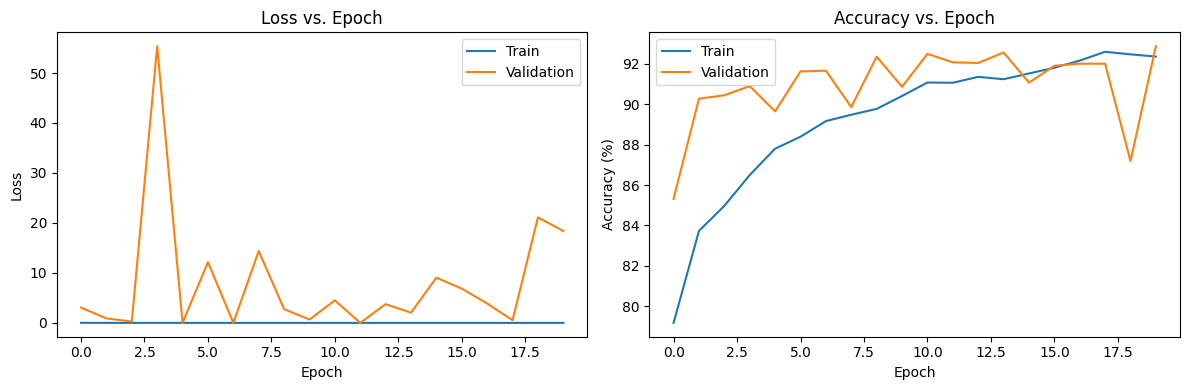

In [12]:
viz_model(training_results)

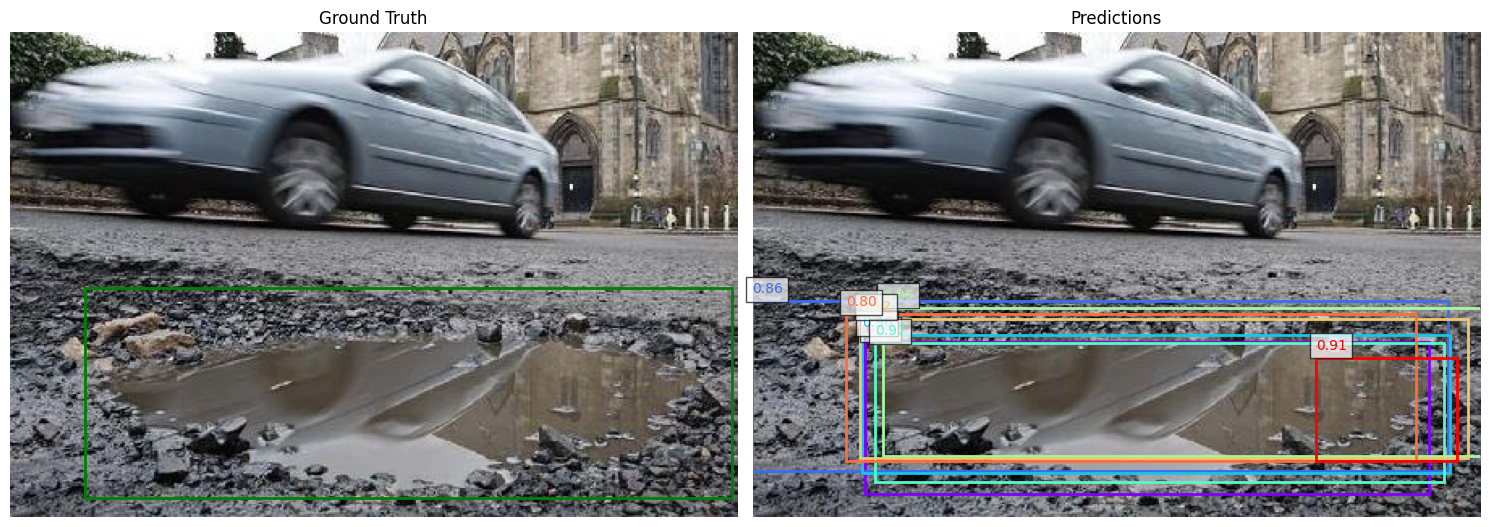

In [13]:
visualize_predictions(model, testset, device, idx=6, conf_threshold=0.5)

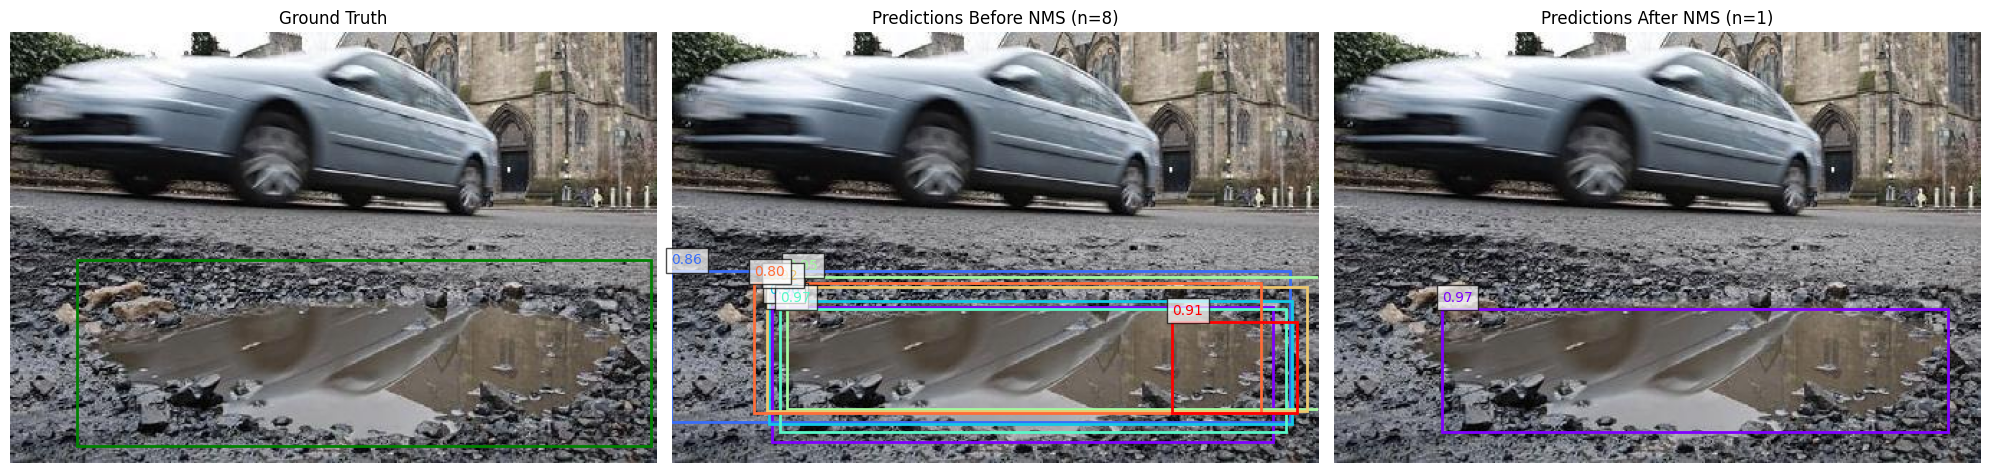

Number of predictions before NMS: 8
Number of predictions after NMS: 1
NMS reduced predictions by: 87.5%


In [14]:
visualize_predictions_with_nms(
        model, testset, device,
        idx=6,
        conf_threshold=0.5,
        nms_threshold=0.01
    )

In [15]:
# Function to use on 1 image at a time, boxes and scores are tensors and iou_threshold is a float
def nms(boxes, scores, iou_threshold):  
    # Sort boxes by scores in descending order
    sorted_indices = torch.argsort(scores, descending=True)
    keep_indices = []

    while len(sorted_indices) > 0:
        # Get the index of the box with the highest score
        box_index = sorted_indices[0]
        keep_indices.append(box_index)

        # Calculate IoU between the current box and all remaining boxes
        ious = ops.box_iou(boxes[box_index].unsqueeze(0), boxes[sorted_indices[1:]])

        # Remove boxes with IoU above the threshold
        sorted_indices = sorted_indices[1:][ious < iou_threshold]

    keep_boxes = boxes[keep_indices]
    keep_scores = scores[keep_indices]

    # Return the kept boxes and scores associated
    return keep_boxes, keep_scores

# Function to run on the entire test set, with boxes, boxes_img, true_boxes and true_boxes_img tensors 
# where a box is at the same position than its image (where it comes from) in the corresponding img tensor. 
# Score is also a tensor and iou_threshold is a float.
# Output is : AP, a list of the precision evolution and a list of the recall evolution (to eventually plot them)
def ap(boxes, boxes_img, true_boxes, true_boxes_img, scores, iou_threshold=0.7):
    # Sort boxes by scores in descending order
    sorted_indices = torch.argsort(scores, descending=True)
    number_boxes=len(true_boxes)
    true_positives = 0
    false_positives = 0
    precision=[]
    recall=[]
    sum_precision=0

    for i, box_index in enumerate(sorted_indices):
        box = boxes[box_index]
        img = boxes_img[box_index]
        img_true_boxes = true_boxes[true_boxes_img == img]
        iou = ops.box_iou(box.unsqueeze(0), img_true_boxes)
        max_iou, max_idx = iou.max(dim=1)
        if max_iou >= iou_threshold:
            true_positives += 1
            true_boxes=torch.cat((true_boxes[:max_idx], true_boxes[max_idx+1:]))
            sum_precision+=true_positives / (true_positives + false_positives)
        else:
            false_positives += 1

        precision.append(true_positives / (true_positives + false_positives))
        recall.append(true_positives / number_boxes)
        
    return sum_precision/number_boxes, precision, recall

# Function to discard all of the background boxes. 
# Boxes and scores are tensors, threshold is a float. 
# Score correspond to sigmoid(output_of_the_model).
def real_boxes(boxes, score, threshold=0.6):
    labels=score>threshold
    boxes=boxes[labels]
    score=score[labels]
    return boxes, score

In [42]:
def AP(gt_boxes, proposed_boxes, proposed_box_probs, threshold=0.5, return_precision_recall=False):
    #gt_boxes: Actual positive class boxes in [xmin, ymin, xmax, ymax] format
    #proposed_boxes: All proposed boxes, in [xmin, ymin, xmax, ymax] format
    #proposed_box_probs: Probability of each proposed box being positive class
    #threshold: IOU threshold for a correct detection
    
    # Sort proposed boxes by probability
    order = np.argsort(proposed_box_probs)[::-1]
    proposed_boxes = np.array(proposed_boxes)[order]
    proposed_box_probs = np.array(proposed_box_probs)[order]
    
    # Use IoU to determine if a box is a true positive
    ious = np.array([[ops.box_iou(gt_box, proposed_box) for gt_box in gt_boxes] for proposed_box in proposed_boxes])
    max_ious = ious.max(axis=1)
    matches_gt_box = max_ious > threshold
    
    # Calculate precision and recall
    TP = np.cumsum(matches_gt_box)
    FP = np.cumsum(~matches_gt_box)
    
    precision = TP / (TP + FP)
    recall = TP / len(gt_boxes)
    
    # Calculate AP
    AP = np.sum(precision * np.diff([0, *recall]))
    
    if return_precision_recall:
        return AP, precision, recall
    
    return AP

In [43]:
def non_maximum_suppression(boxes_w_probs, discard_threshold, consideration_threshold=None, return_indeces = False):
    # NMS for binary classification
    
    # boxes_w_probs should be a list of (bbox, p) tuples
    #    bbox = [xmin, ymin, xmax, ymax] should be AFTER applying alter_box
    #    p should be the probability of the box being in the positive class
    # discard_threshold is the minimum IOU for a box to be discarded (i.e. if box1 and box2 have IOU > discard_threshold, discard the one with lower probability score)
    # consideration_threshold is the minimum probability for a box to be considered. If none, all boxes are considered
    
    
    #add idx
    boxes_w_probs = [(box, prob, idx) for idx, (box, prob) in enumerate(boxes_w_probs)]
    
    
    if consideration_threshold is not None:
        boxes_w_probs = [(box, prob, idx) for box, prob, idx in boxes_w_probs if prob > consideration_threshold]
    
    # Sort the boxes by their probabilities in descending order
    boxes_w_probs.sort(key=lambda x: x[1], reverse=True)
    
    # Initialize an empty list to store the selected boxes
    selected_boxes = []
    selected_indeces = []
    
    while boxes_w_probs:
        # Select the box with the highest probability
        current_box, current_prob, current_idx = boxes_w_probs.pop(0)
        selected_boxes.append((current_box, current_prob))
        selected_indeces.append(current_idx)
        
        # Remove boxes that have high IOU with the current box
        boxes_w_probs = [
            (box, prob, idx) for box, prob, idx in boxes_w_probs
            if ops.box_iou(current_box, box) < discard_threshold
        ]
    
    if return_indeces:
        return selected_boxes, selected_indeces
    else:
        return selected_boxes

In [45]:
def evaluate_ap(model, test_loader, device, conf_threshold=0.2, iou_threshold=0.5, nms_threshold=0.3):
    """
    Evaluate Average Precision on the test set
    """
    model.eval()
    all_boxes = []
    all_scores = []
    all_img_ids = []
    all_gt_boxes = []
    all_gt_img_ids = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images, ground_truths, regions, selected_regions, region_labels, rois = batch
            
            if len(rois) == 0:
                continue
                
            for i in range(len(rois)):
                if len(rois[i]) == 0:
                    continue
                    
                batch_rois = rois[i].to(device)
                batch_regions = selected_regions[i].to(device)
                scores, refined_boxes = model.predict_with_bbox_reg(batch_rois, batch_regions)
                
                object_scores = torch.softmax(scores, dim=1)[:, 1]
                
                mask = object_scores > conf_threshold
                boxes = refined_boxes[mask].float()  # Convert to float
                scores = object_scores[mask].float()  # Convert to float
                
                if len(boxes) > 0:
                    keep_indices = ops.nms(boxes, scores, nms_threshold)
                    boxes = boxes[keep_indices]
                    scores = scores[keep_indices]
                    
                    all_boxes.append(boxes)
                    all_scores.append(scores)
                    all_img_ids.extend([batch_idx * len(rois) + i] * len(boxes))
                    
                all_gt_boxes.append(ground_truths[i].float())  # Convert to float
                all_gt_img_ids.extend([batch_idx * len(rois) + i] * len(ground_truths[i]))

    if len(all_boxes) > 0:
        all_boxes = torch.cat(all_boxes)
        all_scores = torch.cat(all_scores)
        all_img_ids = torch.tensor(all_img_ids, device=device)
    else:
        return 0.0, [], []
        
    all_gt_boxes = torch.cat(all_gt_boxes)
    all_gt_img_ids = torch.tensor(all_gt_img_ids, device=device)
    
    ap_score, precisions, recalls = ap(
        all_boxes, all_img_ids,
        all_gt_boxes, all_gt_img_ids,
        all_scores, iou_threshold
    )
    
    return ap_score, precisions, recalls

Average Precision: 0.4367


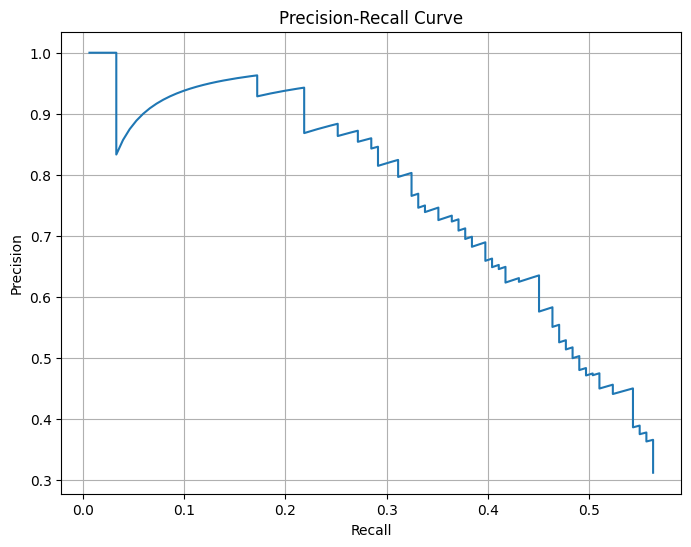

In [46]:
# Example usage:
ap_score, precisions, recalls = evaluate_ap(model, test_loader, device)
print(f"Average Precision: {ap_score:.4f}")
plot_pr_curve(precisions, recalls)